# 0.0 Importando dados do Kaggle

Por causa de limitações da plataforma Kaggle, tive que continuar a edição desse trabalho no Google Collab, por ter mais recursos e mais memoria o que nos possibilita criar nosso modelo de recomendação

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'udemy-courses:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2658012%2F4553658%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240506%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240506T173135Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8fe2b82e02c4b5869dfa10bee37a7da5b64e9117bb9b9877e778f3813f374f93f86ed1c01cb50ed35e59d49ad6f3cdb4bfc366f9ec0184a0a33782e74b3bab10c60fa960d00fe9d5419889ffec18a3aa8fa15a2dabfb02d042f07ffc4bf75020bb46e3bedb0124d26735b1751fed679a824db8fa7e3521c9d23d51e84f871c28f2ec76a2f16adba5f3fa351cebbe01cfdebaa69bb0baa7a7fa8b10dc7daa1f9bd8c633137bb2ba28d0e1903830edf5508aaa314c4799ea7db038a406c514e34eba5a07bae02002622d58a39d6870b76e999bb89a18658094568d3d7d09b28c59e421929824989edfc6c0cb73fde437bba01f6afce964e431c269d1ac860a74e5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 642656495 bytes downloaded
Downloaded and uncompressed: udemy-courses
Data source import complete.


Após realizarmos o download dos dados acima, iremos importar os datasets que contem.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/udemy-courses/Comments.csv
/kaggle/input/udemy-courses/Course_info.csv


# 1.0
# Começando

Começamos importando algumas bibliotecas nas quais serão importantes para a realização de monipulação do nosso dataset, criação de graficos e analise dos dados contidos em suas colunas e linhas.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import warnings
warnings.filterwarnings('ignore')

Aqui definimos a variavel "df" para contem os dados do dataset "Course_info"

In [4]:
df = pd.read_csv("/kaggle/input/udemy-courses/Course_info.csv")

E em seguida já podemos analisar quais são os dados das cinco primeiras linhas do nosso dataset, para que assim já possamos começar a entender melhor quais são os dados que iremos trabalhar.

In [5]:
df.head()

,id,title,is_paid,price,headline,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,content_length_min,published_time,last_update_date,category,subcategory,topic,language,course_url,instructor_name,instructor_url
0,4715.0,Online Vegan Vegetarian Cooking School,True,24.99,Learn to cook delicious vegan recipes. Filmed ...,2231.0,3.75,134.0,42.0,37.0,1268.0,2010-08-05T22:06:13Z,2020-11-06,Lifestyle,Food & Beverage,Vegan Cooking,English,/course/vegan-vegetarian-cooking-school/,Angela Poch,/user/angelapoch/
1,1769.0,The Lean Startup Talk at Stanford E-Corner,False,0.00,Debunking Myths of Entrepreneurship A startup ...,26474.0,4.50,709.0,112.0,9.0,88.0,2010-01-12T18:09:46Z,NaN,Business,Entrepreneurship,Lean Startup,English,/course/the-lean-startup-debunking-myths-of-en...,Eric Ries,/user/ericries/
2,5664.0,"How To Become a Vegan, Vegetarian, or Flexitarian",True,19.99,Get the tools you need for a lifestyle change ...,1713.0,4.40,41.0,13.0,14.0,82.0,2010-10-13T18:07:17Z,2019-10-09,Lifestyle,Other Lifestyle,Vegan Cooking,English,/course/see-my-personal-motivation-for-becomin...,Angela Poch,/user/angelapoch/
3,7723.0,How to Train a Puppy,True,199.99,Train your puppy the right way with Dr. Ian Du...,4988.0,4.80,395.0,88.0,36.0,1511.0,2011-06-20T20:08:38Z,2016-01-13,Lifestyle,Pet Care & Training,Pet Training,English,/course/complete-dunbar-collection/,Ian Dunbar,/user/ian-dunbar/
4,8157.0,Web Design from the Ground Up,True,159.99,Learn web design online: Everything you need t...,1266.0,4.75,38.0,12.0,38.0,569.0,2011-06-23T18:31:20Z,NaN,Design,Web Design,Web Design,English,/course/web-design-from-the-ground-up/,E Learning Lab,/user/edwin-ang-2/


Uma parte importante é conhecer a quantidade de dados, o tipo, se possui valores nulos em cada coluna

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209734 entries, 0 to 209733
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  209734 non-null  float64
 1   title               209734 non-null  object 
 2   is_paid             209734 non-null  bool   
 3   price               209734 non-null  float64
 4   headline            209703 non-null  object 
 5   num_subscribers     209734 non-null  float64
 6   avg_rating          209734 non-null  float64
 7   num_reviews         209734 non-null  float64
 8   num_comments        209734 non-null  float64
 9   num_lectures        209734 non-null  float64
 10  content_length_min  209734 non-null  float64
 11  published_time      209734 non-null  object 
 12  last_update_date    209597 non-null  object 
 13  category            209734 non-null  object 
 14  subcategory         209734 non-null  object 
 15  topic               208776 non-nul

In [7]:
# Verificar se há algum valor nulo no DATA-FRAME
print(df.isnull().sum(), end='\n\n')

# Ver quais os tipos de dados
print(df.dtypes, end='\n\n')

# Ver o tamanho do DATA-FRAME
print(df.shape)

# Descreve o DATA-FRAME
display(df.describe().round(2))

id                      0
title                   0
is_paid                 0
price                   0
headline               31
num_subscribers         0
avg_rating              0
num_reviews             0
num_comments            0
num_lectures            0
content_length_min      0
published_time          0
last_update_date      137
category                0
subcategory             0
topic                 958
language                0
course_url              0
instructor_name         5
instructor_url        427
dtype: int64

id                    float64
title                  object
is_paid                  bool
price                 float64
headline               object
num_subscribers       float64
avg_rating            float64
num_reviews           float64
num_comments          float64
num_lectures          float64
content_length_min    float64
published_time         object
last_update_date       object
category               object
subcategory            object
topic           

,id,price,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,content_length_min
count,209734.00,209734.00,209734.00,209734.00,209734.00,209734.00,209734.00,209734.00
mean,3015403.09,81.67,3096.99,3.75,244.36,44.87,36.55,265.56
std,1342558.02,117.32,15581.32,1.53,2458.10,355.77,51.87,454.45
min,1769.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1950733.50,19.99,26.00,3.80,3.00,1.00,11.00,69.00
50%,3292863.00,34.99,206.00,4.33,17.00,5.00,22.00,133.00
75%,4189458.50,99.99,1435.00,4.62,74.00,18.00,42.00,289.00
max,4914146.00,999.99,1752364.00,5.00,436457.00,39040.00,1095.00,22570.00


In [8]:
df.keys()

Index(['id', 'title', 'is_paid', 'price', 'headline', 'num_subscribers',
       'avg_rating', 'num_reviews', 'num_comments', 'num_lectures',
       'content_length_min', 'published_time', 'last_update_date', 'category',
       'subcategory', 'topic', 'language', 'course_url', 'instructor_name',
       'instructor_url'],
      dtype='object')

In [9]:
df.columns

Index(['id', 'title', 'is_paid', 'price', 'headline', 'num_subscribers',
       'avg_rating', 'num_reviews', 'num_comments', 'num_lectures',
       'content_length_min', 'published_time', 'last_update_date', 'category',
       'subcategory', 'topic', 'language', 'course_url', 'instructor_name',
       'instructor_url'],
      dtype='object')

Após vermos quais são as colunas, dados, se possuem dados nulos ou não, iremos analisar quais são os valores unicos em cada uma das colunas, mostrando que em muitas das colunas possuem valores iguais, nos quais precisamos analisar para verifficar a qualidade dos nossos dados.

In [10]:
df.nunique().sort_values(ascending=False).to_frame().T

,id,course_url,published_time,title,headline,instructor_url,instructor_name,num_subscribers,avg_rating,num_reviews,topic,last_update_date,content_length_min,num_comments,num_lectures,price,subcategory,language,category,is_paid
0,209734,209734,209562,208257,202743,73514,72731,20385,7326,4937,3818,3532,3446,1946,698,236,130,79,13,2


# 1.1

Criaremos um grafico para analisarmos os valores dos cursos.

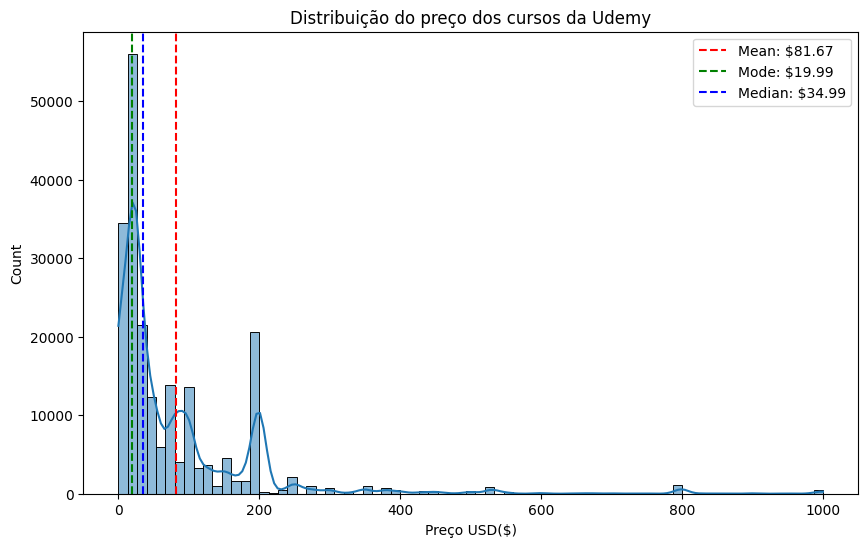

In [11]:
# Configurações do gráfico
fig, ax = plt.subplots(figsize=(10,6), dpi=100)

# Histograma
sns.histplot(data=df, x='price', bins=75, kde=True)

# Média
mean_price = df['price'].mean()
plt.axvline(mean_price, color='r', linestyle='--', label=f'Mean: ${mean_price:.2f}')

# Moda
mode_price = df['price'].mode()[0]
plt.axvline(mode_price, color='g', linestyle='--', label=f'Mode: ${mode_price:.2f}')

# Mediana
median_price = df['price'].median()
plt.axvline(median_price, color='b', linestyle='--', label=f'Median: ${median_price:.2f}')

# Adicionando legenda
plt.legend()

# Adicionando rótulos e título
plt.xlabel("Preço USD($)")
plt.title("Distribuição do preço dos cursos da Udemy")

# Mostrar o gráfico
plt.show()

Acima podemos ver o histograma para uma analise completa de valores dos cursos, e podemos ver e analisar que mais da metade dos cursos estão por menos de $35.00 dolares, e a maioria dos cursos são oferecidos por apenas $19.00 dolares. E abaixo podemos ver uma analise de preço por categoria dos cursos, assim podemos ver quais os "ranges" de preço de cada categoria.

<Axes: xlabel='price', ylabel='category'>

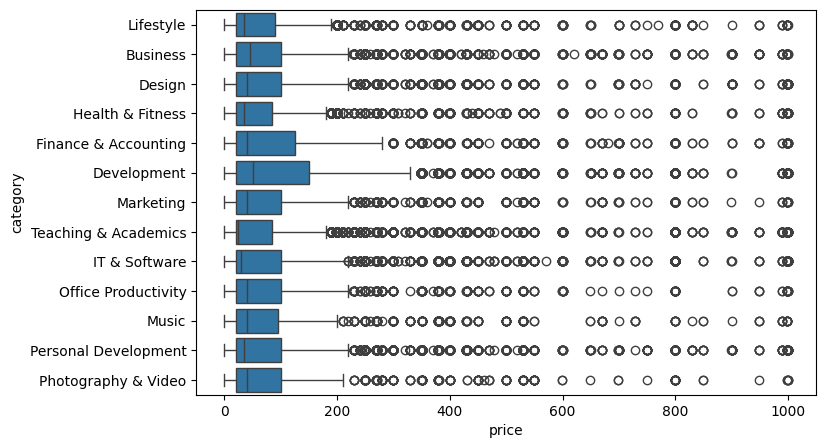

In [12]:
plt.figure(figsize=(8,5), dpi=100)
sns.boxplot(data=df, x='price', y='category')

# 2
# Começando a preparação para os modelos.

Começamos analisando quais são os dados que estão em maior volume, logo com maior relevancia para que possamos analisar e criar um modelo mais enxuto.

In [13]:
# Calcular a contagem de valores únicos para a coluna 'language'
contagem_language = df['language'].value_counts()

# Calcular a porcentagem de cada valor único em relação ao total de observações
porcentagem_language = contagem_language / len(df) * 100

# Calcular a contagem de valores únicos para a coluna 'category'
contagem_category = df['category'].value_counts()

# Calcular a porcentagem de cada valor único em relação ao total de observações
porcentagem_category = contagem_category / len(df) * 100

# Exibir os valores únicos e suas respectivas porcentagens para 'language'
print("Valores únicos e porcentagens para 'language':")
print(contagem_language)
print(porcentagem_language)

# Exibir os valores únicos e suas respectivas porcentagens para 'category'
print("\nValores únicos e porcentagens para 'category':")
print(contagem_category)
print(porcentagem_category)

Valores únicos e porcentagens para 'language':
language
English       123921
Portuguese     18471
Spanish        17428
Turkish         8100
Japanese        7006
               ...  
Welsh              1
Frisian            1
Zulu               1
Tatar              1
Faroese            1
Name: count, Length: 79, dtype: int64
language
English       59.084841
Portuguese     8.806870
Spanish        8.309573
Turkish        3.862035
Japanese       3.340422
                ...    
Welsh          0.000477
Frisian        0.000477
Zulu           0.000477
Tatar          0.000477
Faroese        0.000477
Name: count, Length: 79, dtype: float64

Valores únicos e porcentagens para 'category':
category
Development             31643
IT & Software           30479
Teaching & Academics    26293
Business                24670
Personal Development    21239
Design                  15256
Health & Fitness        11568
Marketing               11221
Lifestyle               10653
Finance & Accounting    10572
Offic

Após analisarmos as porcentagens de cada idioma e categoria, optei por usar apenas os Top 5 Idiomas e categorias para criar nosso modelo, de forma que fique mais preciso e que ajude a diminuir a mesmoria usada para treinar esse modelo.

In [14]:
idiomas_desejados = ['English', 'Portuguese', 'Spanish', 'Turkish', 'Japanese']

df = df[df['language'].isin(idiomas_desejados)]

In [15]:
categorias_desejadas = ['Development', 'IT & Software', 'Teaching & Academics', 'Business', 'Personal Development']

df = df[df['category'].isin(categorias_desejadas)]

df.head()


,id,title,is_paid,price,headline,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,content_length_min,published_time,last_update_date,category,subcategory,topic,language,course_url,instructor_name,instructor_url
1,1769.0,The Lean Startup Talk at Stanford E-Corner,False,0.00,Debunking Myths of Entrepreneurship A startup ...,26474.0,4.50,709.0,112.0,9.0,88.0,2010-01-12T18:09:46Z,NaN,Business,Entrepreneurship,Lean Startup,English,/course/the-lean-startup-debunking-myths-of-en...,Eric Ries,/user/ericries/
7,8082.0,Ruby Programming for Beginners,True,74.99,Learn Ruby Programming the fast and easy way!,28824.0,4.00,741.0,189.0,56.0,363.0,2011-07-08T21:32:55Z,2022-09-26,Development,Programming Languages,Ruby,English,/course/learn-ruby-programming-in-ten-easy-steps/,Huw Collingbourne,/user/huwcollingbourne/
8,8075.0,How to Create an Awesome Demo Video for Your B...,True,149.99,You don't need to spend $10K in order to have ...,10761.0,3.90,349.0,101.0,87.0,526.0,2011-07-06T14:06:34Z,2020-11-22,Business,Media,Demo Video,English,/course/how-to-create-awesome-demo-videos/,Miguel Hernandez,/user/miguelhernandez/
10,8318.0,Navigating the MBA Admissions Process,True,49.99,MBA Admission: The Complete Course on How to G...,794.0,4.10,27.0,16.0,10.0,236.0,2011-07-12T04:11:59Z,NaN,Teaching & Academics,Teacher Training,MBA Admissions,English,/course/business-school/,Clear Admit & Beat The GMAT,/user/clearadmitbeatthegmat/
12,8416.0,Beginners - How To Create iPhone And iPad Apps...,True,49.99,Learn How To Create IOS Apps And Never Do A Ha...,2058.0,3.65,25.0,8.0,81.0,459.0,2011-07-06T23:45:18Z,2017-01-09,Development,Mobile Development,iOS Development,English,/course/beginners-guide-to-iphone-ipad-app-cre...,Infinite Skills,/user/infiniteskills/


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112736 entries, 1 to 209733
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  112736 non-null  float64
 1   title               112736 non-null  object 
 2   is_paid             112736 non-null  bool   
 3   price               112736 non-null  float64
 4   headline            112716 non-null  object 
 5   num_subscribers     112736 non-null  float64
 6   avg_rating          112736 non-null  float64
 7   num_reviews         112736 non-null  float64
 8   num_comments        112736 non-null  float64
 9   num_lectures        112736 non-null  float64
 10  content_length_min  112736 non-null  float64
 11  published_time      112736 non-null  object 
 12  last_update_date    112662 non-null  object 
 13  category            112736 non-null  object 
 14  subcategory         112736 non-null  object 
 15  topic               112245 non-null  ob

In [17]:
# Calcular a contagem de valores únicos para a coluna 'language'
contagem_language = df['language'].value_counts()

# Calcular a porcentagem de cada valor único em relação ao total de observações
porcentagem_language = contagem_language / len(df) * 100

# Calcular a contagem de valores únicos para a coluna 'category'
contagem_category = df['category'].value_counts()

# Calcular a porcentagem de cada valor único em relação ao total de observações
porcentagem_category = contagem_category / len(df) * 100

# Exibir os valores únicos e suas respectivas porcentagens para 'language'
print("Valores únicos e porcentagens para 'language':")
print(contagem_language)
print(porcentagem_language)

# Exibir os valores únicos e suas respectivas porcentagens para 'category'
print("\nValores únicos e porcentagens para 'category':")
print(contagem_category)
print(porcentagem_category)

Valores únicos e porcentagens para 'language':
language
English       80114
Portuguese    12051
Spanish       10911
Turkish        5587
Japanese       4073
Name: count, dtype: int64
language
English       71.063369
Portuguese    10.689576
Spanish        9.678364
Turkish        4.955826
Japanese       3.612865
Name: count, dtype: float64

Valores únicos e porcentagens para 'category':
category
IT & Software           26790
Development             26279
Teaching & Academics    21782
Business                20349
Personal Development    17536
Name: count, dtype: int64
category
IT & Software           23.763483
Development             23.310211
Teaching & Academics    19.321246
Business                18.050135
Personal Development    15.554925
Name: count, dtype: float64


In [18]:
idiomas_desejados = ['English', 'Portuguese', 'Spanish', 'Turkish', 'Japanese']

df = df[df['language'].isin(idiomas_desejados)]

In [19]:
categorias_desejadas = ['Development', 'IT & Software', 'Teaching & Academics', 'Business', 'Personal Development']

df = df[df['category'].isin(categorias_desejadas)]

df.head()

,id,title,is_paid,price,headline,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,content_length_min,published_time,last_update_date,category,subcategory,topic,language,course_url,instructor_name,instructor_url
1,1769.0,The Lean Startup Talk at Stanford E-Corner,False,0.00,Debunking Myths of Entrepreneurship A startup ...,26474.0,4.50,709.0,112.0,9.0,88.0,2010-01-12T18:09:46Z,NaN,Business,Entrepreneurship,Lean Startup,English,/course/the-lean-startup-debunking-myths-of-en...,Eric Ries,/user/ericries/
7,8082.0,Ruby Programming for Beginners,True,74.99,Learn Ruby Programming the fast and easy way!,28824.0,4.00,741.0,189.0,56.0,363.0,2011-07-08T21:32:55Z,2022-09-26,Development,Programming Languages,Ruby,English,/course/learn-ruby-programming-in-ten-easy-steps/,Huw Collingbourne,/user/huwcollingbourne/
8,8075.0,How to Create an Awesome Demo Video for Your B...,True,149.99,You don't need to spend $10K in order to have ...,10761.0,3.90,349.0,101.0,87.0,526.0,2011-07-06T14:06:34Z,2020-11-22,Business,Media,Demo Video,English,/course/how-to-create-awesome-demo-videos/,Miguel Hernandez,/user/miguelhernandez/
10,8318.0,Navigating the MBA Admissions Process,True,49.99,MBA Admission: The Complete Course on How to G...,794.0,4.10,27.0,16.0,10.0,236.0,2011-07-12T04:11:59Z,NaN,Teaching & Academics,Teacher Training,MBA Admissions,English,/course/business-school/,Clear Admit & Beat The GMAT,/user/clearadmitbeatthegmat/
12,8416.0,Beginners - How To Create iPhone And iPad Apps...,True,49.99,Learn How To Create IOS Apps And Never Do A Ha...,2058.0,3.65,25.0,8.0,81.0,459.0,2011-07-06T23:45:18Z,2017-01-09,Development,Mobile Development,iOS Development,English,/course/beginners-guide-to-iphone-ipad-app-cre...,Infinite Skills,/user/infiniteskills/


# 2.1

# Arrumando a coluna que contem datas

Para deixar visualmente mais facil e limpo, retirei os dados de hora na qual o curso foi publicado, assim deixando uma visualização mais limpa e harmonioza.

In [20]:
df['published_time'] = df['published_time'].apply(lambda x: x.split('T')[0])

In [21]:
df['last_update_date'].fillna(df['published_time'], inplace=True)

In [22]:
quantidas_anual = df.groupby('published_time')['published_time'].size().sort_values(ascending=False)

In [23]:
total_publications = df['published_time'].size
quantidas_anual = (quantidas_anual / total_publications) * 100

In [24]:
print(pd.DataFrame({'published_time': quantidas_anual.index, 'Count': quantidas_anual.values, 'Percentage': quantidas_anual.values}))

     published_time     Count  Percentage
0        2020-05-12  0.125958    0.125958
1        2020-05-20  0.123297    0.123297
2        2020-05-14  0.115314    0.115314
3        2020-05-13  0.115314    0.115314
4        2021-02-04  0.114427    0.114427
...             ...       ...         ...
3611     2013-05-28  0.000887    0.000887
3612     2013-06-03  0.000887    0.000887
3613     2013-06-09  0.000887    0.000887
3614     2013-06-10  0.000887    0.000887
3615     2010-01-12  0.000887    0.000887

[3616 rows x 3 columns]


Acima estava vendo quais as datas tiveram mais envios de cursos, porém como o nosso modelo ainda estava muito pesado, optei apenas por usar os cursos postados a partir de 2019, para que assim mantermos os cursos sobre tecnologia mais atualizados devido ao mercado se atualizar cada vez mais rapidamente.

In [25]:
df['last_update_date'] = pd.to_datetime(df['last_update_date'])

# Remover linhas com datas anteriores a 2019
df = df[df['last_update_date'].dt.year >= 2019]


# 2.2

# Avaliando as quantidas de avaliações e e media das avaliações

Abaixo para que possamos recomendar cursos de melhor qualidade, fiz uma avaliação para vermos a quantidade de cursos com as avaliações e qualidade das avaliações para mantermos apenas cursos com mais de 10 avaliações com notas media acima de 3.75, assim manteremos um alto padrão para que possamos recomendar cursos de qualidade.

In [26]:
quantidade = df['num_reviews'].value_counts()

porcentagem = (quantidade / len(df)) * 100

df_unique_reviews = pd.DataFrame({'Quantidade': quantidade, 'Porcentagem': porcentagem})

df_unique_reviews = df_unique_reviews.sort_values(by='Quantidade', ascending=False)

print(df_unique_reviews)


             Quantidade  Porcentagem
num_reviews                         
0.0               12927    13.549888
1.0                5422     5.683259
2.0                4063     4.258776
3.0                3516     3.685419
4.0                2765     2.898232
...                 ...          ...
4558.0                1     0.001048
2255.0                1     0.001048
36123.0               1     0.001048
3148.0                1     0.001048
2264.0                1     0.001048

[3836 rows x 2 columns]


In [27]:
quantidade_avg_rating = df['avg_rating'].value_counts()

porcentagem_avg_rating = (quantidade_avg_rating / len(df)) * 100

df_unique_avg_rating = pd.DataFrame({'Quantidade': quantidade_avg_rating, 'Porcentagem': porcentagem_avg_rating})

df_unique_avg_rating = df_unique_avg_rating.sort_values(by='Quantidade', ascending=False)

print(df_unique_avg_rating)


            Quantidade  Porcentagem
avg_rating                         
0.000000         12935    13.558274
5.000000          6293     6.596229
4.500000          4759     4.988313
4.000000          3192     3.345807
4.250000          2483     2.602644
...                ...          ...
3.959184             1     0.001048
4.606122             1     0.001048
4.512228             1     0.001048
4.661202             1     0.001048
4.787313             1     0.001048

[5757 rows x 2 columns]


Abaixo após as avaliações das linhas acima, descartamos os cursos que tem media de avaliação menor de 3.75 e com menos de 10 avaliações.

In [28]:
df = df.drop(df[(df['avg_rating'] < 3.75) & (df['num_reviews'] < 10)].index)

df = df.reset_index(drop=True)

In [29]:
df.head()

,id,title,is_paid,price,headline,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,content_length_min,published_time,last_update_date,category,subcategory,topic,language,course_url,instructor_name,instructor_url
0,8082.0,Ruby Programming for Beginners,True,74.99,Learn Ruby Programming the fast and easy way!,28824.0,4.000000,741.0,189.0,56.0,363.0,2011-07-08,2022-09-26,Development,Programming Languages,Ruby,English,/course/learn-ruby-programming-in-ten-easy-steps/,Huw Collingbourne,/user/huwcollingbourne/
1,8075.0,How to Create an Awesome Demo Video for Your B...,True,149.99,You don't need to spend $10K in order to have ...,10761.0,3.900000,349.0,101.0,87.0,526.0,2011-07-06,2020-11-22,Business,Media,Demo Video,English,/course/how-to-create-awesome-demo-videos/,Miguel Hernandez,/user/miguelhernandez/
2,8324.0,Javascript for Beginners,True,19.99,Learn javascript online and supercharge your w...,9714.0,4.408389,1081.0,194.0,48.0,183.0,2011-07-09,2020-10-03,Development,Web Development,JavaScript,English,/course/beginning-javascript/,Dollar Design School,/user/marklassoff/
3,8849.0,Speak Up! Stand Out and be HAPPY,True,44.99,Polish your communication skills by learning s...,7791.0,4.600000,545.0,149.0,26.0,176.0,2011-08-22,2020-03-20,Business,Communication,Public Speaking,English,/course/speak-up/,Alexa Fischer,/user/alexafischer/
4,10620.0,Practical Transformation Using XSLT and XPath ...,True,179.99,5-day class for transforming XML covers every ...,1168.0,4.550000,217.0,41.0,71.0,1441.0,2011-10-28,2020-05-03,Development,Web Development,XSLT,English,/course/practical-transformation-using-xslt-an...,G. Ken Holman,/user/gkenholman/


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77608 entries, 0 to 77607
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  77608 non-null  float64       
 1   title               77608 non-null  object        
 2   is_paid             77608 non-null  bool          
 3   price               77608 non-null  float64       
 4   headline            77604 non-null  object        
 5   num_subscribers     77608 non-null  float64       
 6   avg_rating          77608 non-null  float64       
 7   num_reviews         77608 non-null  float64       
 8   num_comments        77608 non-null  float64       
 9   num_lectures        77608 non-null  float64       
 10  content_length_min  77608 non-null  float64       
 11  published_time      77608 non-null  object        
 12  last_update_date    77608 non-null  datetime64[ns]
 13  category            77608 non-null  object    

# 3

# modelo

Após diminuirmos nosso dataset de mais de 207000 linhas, após nossas filtragens de conteudo conseguimos reduzir para pouco mais de 77000, uma boa redução, porém como nosso modelo de recomendação será baseado em recomendações pelo titulo do curso, usaremos a bliblioteca "neattext" para que possamos limpar os dados da coluna "titulo", tirando caracteres especiais, palavras repetidas, emojis, caracteres especiais e mais algumas palavras que não são relevantes. Deixando assim nosso dataset mais leve para os proximos passos.

In [32]:
pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.0 MB/s eta 0:00:00


Novamente importando as bibliotecas que farão parte do nosso modelo.

In [33]:
import neattext.functions as nfx
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel

Aqui chamamos a função dir() para listar todos os atributos e métodos disponíveis no módulo nfx. Isso incluirá todas as funções disponíveis na biblioteca neattext que podem ser usadas para manipulação e limpeza de texto.

In [34]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [35]:
df['title_limpo'] = df['title'].apply(nfx.remove_stopwords)

In [36]:
df['title_limpo'] = df['title_limpo'].apply(nfx.remove_special_characters)

Após a limpeza dos titulos, podemos comparar os titulos antes e depois para ver a limpeza dos dados em ação.

In [37]:
df[['title','title_limpo']]

,title,title_limpo
0,Ruby Programming for Beginners,Ruby Programming Beginners
1,How to Create an Awesome Demo Video for Your B...,Create Awesome Demo Video Business
2,Javascript for Beginners,Javascript Beginners
3,Speak Up! Stand Out and be HAPPY,Speak Up Stand HAPPY
4,Practical Transformation Using XSLT and XPath ...,Practical Transformation XSLT XPath 5hour free...
...,...,...
77603,AWS Certified Solutions Architect Professional...,AWS Certified Solutions Architect Professional...
77604,Human Resource Management,Human Resource Management
77605,Static Timing Analysis: VLSI,Static Timing Analysis VLSI
77606,Spiritual Mindfulness,Spiritual Mindfulness


Mesmo após todas essa reduções que fizemos, o nosso modelo ainda estava muito pesado e não conseguimos rodas, por isso infelizmente tive que dividir os dados em 3 partes, para conseguir fazer com que o treinamendo do modelo fosse completado.

In [38]:
sample_size = len(df) // 3

# Selecionar uma amostra aleatória das colunas 'title' e 'title_limpo'
random_sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
df = df.iloc[random_sample_indices]

# Resetar os índices
df = df.reset_index(drop=True)

count_vect = CountVectorizer(). Isso cria uma instância do objeto CountVectorizer da biblioteca scikit-learn. CountVectorizer é usado para converter uma coleção de documentos de texto em uma matriz de contagens de tokens.


In [39]:
count_vect = CountVectorizer()
cv_mat = count_vect.fit_transform(df['title_limpo'])


cv_mat = count_vect.fit_transform(df['title_limpo']). Aqui, o método fit_transform do objeto CountVectorizer é usado para ajustar o vetorizador aos dados de texto na coluna 'title_limpo' do DataFrame df e transformá-lo em uma matriz de contagem de palavras. A matriz resultante é atribuída à variável cv_mat.


In [40]:
cv_mat

<25869x19104 sparse matrix of type '<class 'numpy.int64'>'
	with 130742 stored elements in Compressed Sparse Row format>

cv_mat. Isso imprime a matriz resultante após a transformação pelo CountVectorizer. Esta matriz contém contagens de ocorrências de tokens (palavras) nos documentos de texto.



In [41]:
cv_mat.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

cv_mat.todense(). O método todense() é chamado na matriz cv_mat para converter a matriz esparsa em uma matriz densa, o que facilita a visualização e a manipulação dos dados.


In [42]:
df_cv_words = pd.DataFrame(cv_mat.todense(),columns=count_vect.get_feature_names_out())
df_cv_words.head()

,003,004,01,010150,010160,010yrs,01million,02,0270,03,...,zoompowerpoint3,zor,zorbalik,zorbalk,zos,zotero,zowe,zpl,zpmp,zye
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



df_cv_words = pd.DataFrame(cv_mat.todense(),columns=count_vect.get_feature_names_out()): Isso cria um DataFrame do pandas chamado df_cv_words a partir da matriz densa resultante da contagem de palavras. Os nomes das colunas do DataFrame são definidos como os tokens (palavras) extraídos dos documentos de texto usando o método get_feature_names_out() do objeto CountVectorizer.


In [43]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
cosine_sim_mat = cosine_similarity(cv_mat)

cosine_sim_mat = cosine_similarity(cv_mat). Isso calcula a matriz de similaridade do cosseno entre os vetores de documentos representados pela matriz de contagem de palavras cv_mat. A similaridade do cosseno é uma medida comum usada para determinar a semelhança entre dois vetores de alta dimensão.



In [45]:
cosine_sim_mat

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.24806947, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.24806947, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [46]:
course_indices = pd.Series(df.index,index=df['title']).drop_duplicates()

In [47]:
course_indices

title
Personal Communication-Introduce Yourself With Confidence          0
How To Get Started In The ATM Business- Complete Blueprint         1
Home Business Freelancing Online. Freelancing Home Business        2
Effective Time Management Skills - Time Management Skills          3
Spatial Analysis and Geospatial Data Science With Python           4
                                                               ...  
Design Patterns In PHP OOP for PHP Projects & Interviews       25864
Oracle Process Cloud (PCS)                                     25865
SACRED PSYCHEDELICS 2.0                                        25866
Dental applications of Nanotechnology                          25867
SAP LSMW Made Simple                                           25868
Length: 25869, dtype: int64

In [50]:
course_indices['Oracle Process Cloud (PCS)']

25865

In [51]:
idx = course_indices['Oracle Process Cloud (PCS)']

In [52]:
scores = list(enumerate(cosine_sim_mat[idx]))

scores = list(enumerate(cosine_sim_mat[idx])). Aqui, os escores de similaridade entre o curso fornecido (identificado pelo índice idx) e todos os outros cursos são extraídos da matriz de similaridade do cosseno. Os índices dos cursos e seus escores correspondentes são armazenados em uma lista.


In [53]:
scores

[(0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.0),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.25),
 (16, 0.0),
 (17, 0.0),
 (18, 0.0),
 (19, 0.0),
 (20, 0.0),
 (21, 0.0),
 (22, 0.0),
 (23, 0.0),
 (24, 0.0),
 (25, 0.0),
 (26, 0.0),
 (27, 0.0),
 (28, 0.0),
 (29, 0.0),
 (30, 0.0),
 (31, 0.0),
 (32, 0.0),
 (33, 0.0),
 (34, 0.0),
 (35, 0.0),
 (36, 0.0),
 (37, 0.0),
 (38, 0.0),
 (39, 0.0),
 (40, 0.0),
 (41, 0.0),
 (42, 0.0),
 (43, 0.0),
 (44, 0.0),
 (45, 0.0),
 (46, 0.0),
 (47, 0.0),
 (48, 0.0),
 (49, 0.0),
 (50, 0.0),
 (51, 0.0),
 (52, 0.0),
 (53, 0.0),
 (54, 0.0),
 (55, 0.0),
 (56, 0.0),
 (57, 0.0),
 (58, 0.0),
 (59, 0.0),
 (60, 0.0),
 (61, 0.0),
 (62, 0.0),
 (63, 0.0),
 (64, 0.0),
 (65, 0.0),
 (66, 0.0),
 (67, 0.0),
 (68, 0.0),
 (69, 0.0),
 (70, 0.0),
 (71, 0.0),
 (72, 0.0),
 (73, 0.0),
 (74, 0.0),
 (75, 0.0),
 (76, 0.0),
 (77, 0.0),
 (78, 0.0),
 (79, 0.0),
 (80, 0.0),
 (81, 0.0),
 (82, 0.0),
 (83, 0.0),
 

In [54]:
sorted_scores = sorted(scores,key=lambda x:x[1],reverse=True)
sorted_scores[1:]

[(20018, 0.5669467095138407),
 (6596, 0.5303300858899106),
 (22919, 0.5),
 (3638, 0.4472135954999579),
 (6226, 0.4472135954999579),
 (11201, 0.4472135954999579),
 (11632, 0.4472135954999579),
 (11639, 0.4472135954999579),
 (15404, 0.4472135954999579),
 (22833, 0.4472135954999579),
 (3271, 0.43301270189221935),
 (5273, 0.43301270189221935),
 (7565, 0.43301270189221935),
 (18970, 0.43301270189221935),
 (7409, 0.41602514716892186),
 (267, 0.4082482904638631),
 (644, 0.4082482904638631),
 (815, 0.4082482904638631),
 (4073, 0.4082482904638631),
 (5427, 0.4082482904638631),
 (6477, 0.4082482904638631),
 (6790, 0.4082482904638631),
 (9531, 0.4082482904638631),
 (10553, 0.4082482904638631),
 (10780, 0.4082482904638631),
 (12382, 0.4082482904638631),
 (13887, 0.4082482904638631),
 (16452, 0.4082482904638631),
 (17987, 0.4082482904638631),
 (18265, 0.4082482904638631),
 (19840, 0.4082482904638631),
 (20723, 0.4082482904638631),
 (21369, 0.4082482904638631),
 (22031, 0.4082482904638631),
 (22703,


sorted_scores = sorted(scores,key=lambda x:x[1],reverse=True). Os escores de similaridade são classificados em ordem decrescente com base nos valores de similaridade.

selected_course_indices = [i[0] for i in sorted_scores[1:]]. Aqui, os índices dos cursos recomendados são extraídos da lista classificada de escores de similaridade. O primeiro curso é excluído porque é o próprio curso fornecido.


In [55]:
selected_course_indices = [i[0] for i in sorted_scores[1:]]
selected_course_indices

[20018,
 6596,
 22919,
 3638,
 6226,
 11201,
 11632,
 11639,
 15404,
 22833,
 3271,
 5273,
 7565,
 18970,
 7409,
 267,
 644,
 815,
 4073,
 5427,
 6477,
 6790,
 9531,
 10553,
 10780,
 12382,
 13887,
 16452,
 17987,
 18265,
 19840,
 20723,
 21369,
 22031,
 22703,
 22832,
 22924,
 25403,
 2391,
 4690,
 7185,
 7310,
 9016,
 10936,
 10998,
 11665,
 11938,
 12534,
 13752,
 14325,
 14811,
 15697,
 16248,
 16351,
 16473,
 19131,
 19198,
 20173,
 21386,
 22195,
 25506,
 2226,
 2662,
 3894,
 4071,
 5424,
 10111,
 11439,
 14797,
 20379,
 24526,
 2062,
 7125,
 7770,
 7985,
 15622,
 16791,
 17102,
 17267,
 20482,
 5269,
 9441,
 17346,
 17686,
 19871,
 23235,
 25269,
 855,
 702,
 3108,
 4733,
 4781,
 8787,
 9677,
 12071,
 15018,
 15394,
 16599,
 16871,
 17204,
 17252,
 18016,
 18406,
 18860,
 19475,
 21468,
 22243,
 25797,
 486,
 11571,
 15,
 458,
 1034,
 1246,
 1327,
 2383,
 2598,
 3200,
 3682,
 4768,
 5050,
 6567,
 6645,
 6961,
 7040,
 8227,
 8772,
 9636,
 10177,
 10691,
 10773,
 11242,
 11602,
 1

In [56]:
selected_course_scores = [i[1] for i in sorted_scores[1:]]
recommended_result = df['title'].iloc[selected_course_indices]
rec_df = pd.DataFrame(recommended_result)
rec_df.head()

,title
20018,Oracle Cloud Infrastructure- Part 1 ( Fundamen...
6596,Basics in Plan to Produce (P2P) Process: Oracl...
22919,Oracle Fusion Technical - Oracle Integration ...
3638,1Z0-1049-22 Oracle Compensation Cloud 2022
6226,Oracle Cloud Database Services Specialist


selected_course_scores = [i[1] for i in sorted_scores[1:]]. Os escores de similaridade correspondentes aos cursos recomendados são armazenados em uma lista separada.

recommended_result = df['title'].iloc[selected_course_indices]. Os títulos dos cursos recomendados são extraídos do DataFrame original df com base nos índices dos cursos recomendados.

In [57]:
rec_df['similarity_scores'] = selected_course_scores
rec_df

,title,similarity_scores
20018,Oracle Cloud Infrastructure- Part 1 ( Fundamen...,0.566947
6596,Basics in Plan to Produce (P2P) Process: Oracl...,0.530330
22919,Oracle Fusion Technical - Oracle Integration ...,0.500000
3638,1Z0-1049-22 Oracle Compensation Cloud 2022,0.447214
6226,Oracle Cloud Database Services Specialist,0.447214
...,...,...
25863,Apple Mac for Absolute Beginners,0.000000
25864,Design Patterns In PHP OOP for PHP Projects & ...,0.000000
25866,SACRED PSYCHEDELICS 2.0,0.000000
25867,Dental applications of Nanotechnology,0.000000


rec_df['similarity_scores'] = selected_course_scores. Os escores de similaridade correspondentes são adicionados ao DataFrame rec_df para fornecer informações sobre a similaridade de cada curso recomendado com o curso fornecido.

In [58]:
def recommend_course(title, num_of_rec=10, min_similarity=0.0):

    if title not in course_indices:
        raise ValueError(f"Course title '{title}' not found in data.")

    idx = course_indices[title]
    scores = pd.Series(cosine_sim_mat[idx], index=course_indices)

    filtered_scores = scores[scores >= min_similarity].sort_values(ascending=False)

    if filtered_scores.empty:
        return pd.DataFrame(columns=['title', 'similarity_scores'])

    selected_course_indices = filtered_scores.index[1:num_of_rec + 1]
    selected_course_scores = list(filtered_scores.iloc[1:num_of_rec + 1])

    result = df['title'].iloc[selected_course_indices]
    rec_df = pd.DataFrame({'title': result, 'similarity_scores': selected_course_scores})

    return rec_df.head(num_of_rec)

Abaixo podemos ver quais as recomendações e suas similariedades dos cursos com base no curso 'Oracle Process Cloud (PCS)'

In [60]:
recommend_course('Oracle Process Cloud (PCS)',20)

,title,similarity_scores
20018,Oracle Cloud Infrastructure- Part 1 ( Fundamen...,0.566947
6596,Basics in Plan to Produce (P2P) Process: Oracl...,0.530330
22919,Oracle Fusion Technical - Oracle Integration ...,0.500000
3638,1Z0-1049-22 Oracle Compensation Cloud 2022,0.447214
6226,Oracle Cloud Database Services Specialist,0.447214
11201,Oracle Cloud Infrastructure Foundations-Oracle...,0.447214
11632,Fundamentals/Basics in Oracle WMS Cloud: SCM,0.447214
11639,Managing Oracle Cloud Autonomous Databases,0.447214
15404,Learn Oracle Cloud Infrastructure Fundamentals,0.447214
22833,1Z0-1065-22 Oracle Procurement Cloud 2022,0.447214
